In [14]:
!pip install wget
import wget
import os
import tarfile
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

I am using [the labeled faces in the wild](http://vis-www.cs.umass.edu/lfw/) dataset here, which is a daset of 13233 images of faces. This is a useful dataset as I can just download it with wget so it works well when using colab.

In [0]:
if not os.path.exists('./data'):
    os.mkdir('./data')
    url = 'http://vis-www.cs.umass.edu/lfw/lfw.tgz'
    wget.download(url, './data/LFW.tar.gz')
    fname = './data/LFW.tar.gz'
    tar = tarfile.open(fname, "r:gz")
    tar.extractall('./data')
    tar.close()

In [0]:
class DsLoader():
    def __init__(self, dir_path):
        self.dir_path = dir_path

    def get_ds(self, batch_size=32, image_size=(64, 64), augment=False, n_repeats=1):
        self.image_size=image_size

        list_ds = tf.data.Dataset.list_files(self.dir_path + '/*/*.jpg')

        # Set `num_parallel_calls` so multiple images are loaded/processed
        # in parallel.
        self.AUTOTUNE = tf.data.experimental.AUTOTUNE
        labeled_ds = list_ds.map(
            self.process_path,
            num_parallel_calls=self.AUTOTUNE,
        )

        ds = self.prepare_for_training(labeled_ds, batch_size, augment=augment, n_repeats=n_repeats)
        return ds

    def decode_img(self, img):
        # convert the compressed string to a 3D uint8 tensor
        img = tf.image.decode_jpeg(img, channels=3)
        # Use `convert_image_dtype` to convert to floats in the [-1,1] range.
        img = (tf.image.convert_image_dtype(img, tf.float32)*2)-1
        # resize the image to the desired size.
        return tf.image.resize(img, self.image_size)

    def process_path(self, file_path):
        # load the raw data from the file as a string
        img = tf.io.read_file(file_path)
        img = self.decode_img(img)
        return img

    def prepare_for_training(self,
                             ds,
                             batch_size,
                             cache=True,
                             shuffle_buffer_size=1000,
                             augment=False,
                             n_repeats=0):
        # This is a small dataset, only load it once, and keep it in memory.
        # use `.cache(filename)` to cache preprocessing work for datasets
        # that don't fit in memory.
        if cache:
            if isinstance(cache, str):
                ds = ds.cache(cache)
            else:
                ds = ds.cache()

        ds = ds.shuffle(buffer_size=shuffle_buffer_size)

        # Augment the images
        if augment:
            ds = ds.map(self.flip)
            ds = ds.map(self.rotate)

        # Repeat if required
        ds = ds.repeat(n_repeats)

        ds = ds.batch(batch_size, drop_remainder=True)

        # `prefetch` lets the dataset fetch batches in the background while
        # the model is training
        ds = ds.prefetch(buffer_size=self.AUTOTUNE)

        return ds

    def flip(self, x, y):
        """Flip an image up and down and left and right randomly

        Args:
            x: Image

        Returns:
            Augmented image
        """
        x = tf.image.random_flip_left_right(x)
        x = tf.image.random_flip_up_down(x)

        return x, y

    def rotate(self, x, y):
        """Randomly rotate and image by a multiple of 90 degrees

        Args:
            x: Image

        Returns:
            Augmented image
        """

        x = tf.image.rot90(
            x, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
        return x, y



In [0]:
dsl = DsLoader('./data/lfw')

In [0]:
dataset = dsl.get_ds(batch_size=32, image_size=(128,128))

In [0]:
def plot_batch(batch):
    out = []
    img_size = batch[0].shape
    batch_size = len(batch)
    cols = batch_size//4
    for i in range(cols):
        out.append(np.vstack(batch[i*4:i*4+4]))
    out = np.hstack(out)
    # Undo transfomration to [-1, 1]
    out = (out + 1)/2
    fig, ax = plt.subplots(figsize=(12, 24))
    ax.imshow(out,cmap='gray')
    ax.axis('off')

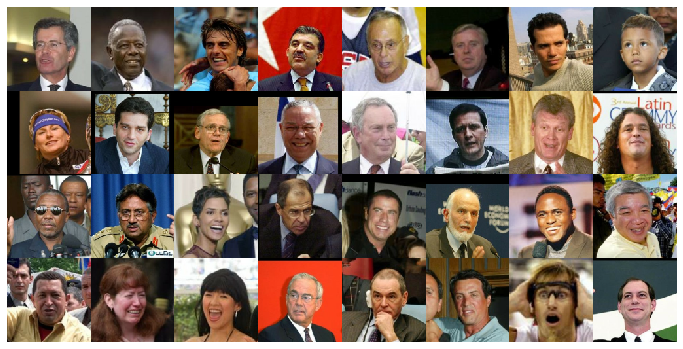

In [96]:
# Plotting one batch of images
it = iter(dataset)
batch = next(it)
plot_batch(batch)

In [0]:
# Code to train generator (exaclty the same as in simple_gan.ipynb)
def train_gan(gan, dataset, batch_size, codings_size, n_epochs):
    generator, discriminator = gan.layers
    for epoch in tqdm(range(n_epochs)):
        for X_batch in dataset:
            # train discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)

            # train generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)

I have added an addtional layer compared to the network I used in simple_GANs.ipynb and scaled up the network so that it outputs images of size (128, 128)

In [0]:
codings_size = 100

cgan_generator = keras.models.Sequential([
    keras.layers.Dense(16*16*128, input_shape=[codings_size]),
    keras.layers.Reshape([16, 16, 128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="same", activation="selu"),
    keras.layers.BatchNormalization(),
        keras.layers.Conv2DTranspose(32, kernel_size=5, strides=2, padding="same", activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(3, kernel_size=5, strides=2, padding="same", activation="tanh"),
],name='generator')

cgan_discriminator = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=5, strides=2, padding="same", activation=keras.layers.LeakyReLU(0.2), input_shape=cgan_generator.output.shape[1:]),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="same", activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="same", activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation='sigmoid')
],name='discriminator')

cgan = keras.models.Sequential([cgan_generator, cgan_discriminator])

cgan_discriminator.compile(loss='binary_crossentropy', optimizer='rmsprop')
cgan_discriminator.trainable = False
cgan.compile(loss='binary_crossentropy', optimizer='rmsprop')

In [102]:
# Check the outputs of the gnerator and the input of the discriminator are the same
print(cgan_generator.output.shape)
print(cgan_discriminator.input.shape)

(None, 128, 128, 3)
(None, 128, 128, 3)


In [113]:
# Takes c. 10 minuts for 25 epochs on colab with gpu
train_gan(cgan, dataset, batch_size=32, codings_size=codings_size, n_epochs=25)







  0%|          | 0/25 [00:00<?, ?it/s]





  4%|▍         | 1/25 [00:20<08:20, 20.84s/it]





  8%|▊         | 2/25 [00:41<07:57, 20.78s/it]





 12%|█▏        | 3/25 [01:02<07:36, 20.76s/it]





 16%|█▌        | 4/25 [01:22<07:15, 20.73s/it]





 20%|██        | 5/25 [01:43<06:53, 20.69s/it]





 24%|██▍       | 6/25 [02:04<06:32, 20.65s/it]





 28%|██▊       | 7/25 [02:24<06:11, 20.65s/it]





 32%|███▏      | 8/25 [02:45<05:50, 20.62s/it]





 36%|███▌      | 9/25 [03:05<05:29, 20.59s/it]





 40%|████      | 10/25 [03:26<05:08, 20.57s/it]





 44%|████▍     | 11/25 [03:46<04:47, 20.55s/it]





 48%|████▊     | 12/25 [04:07<04:27, 20.55s/it]





 52%|█████▏    | 13/25 [04:27<04:06, 20.54s/it]





 56%|█████▌    | 14/25 [04:48<03:45, 20.54s/it]





 60%|██████    | 15/25 [05:08<03:25, 20.54s/it]





 64%|██████▍   | 16/25 [05:29<03:05, 20.58s/it]





 68%|██████▊   | 17/25 [05:50<02:44, 20.56s/it]





 72%|███████▏  | 18/25 [06:10<02:23, 20.54s/it]





 76%|

Checking the results of the network - the defintley look like faces but are not totally convincing

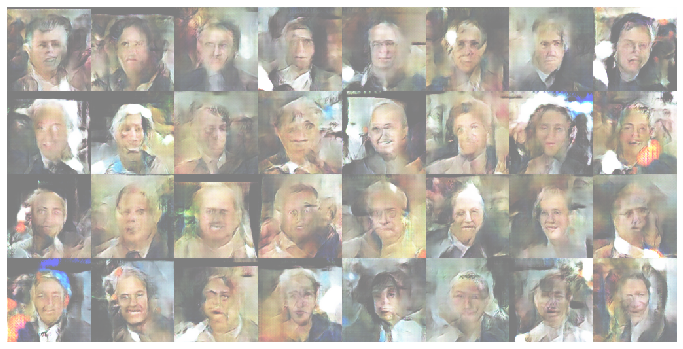

In [114]:
noise = tf.random.normal(shape=[32, codings_size])
generated_images = cgan_generator(noise)
# Undo the transformaton on the dataset
generated_images = (generated_images+1)/2
plot_batch(generated_images)